In [19]:
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from PIL import Image

from kuramoto import GeneralizedKuramoto

In [20]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.6)

# grid parameters
grid_size = 64
n_nodes = grid_size * grid_size
dim = 2  # 2D vectors

# conditional stimuli c_i
def load_binary_mask(image_path, size=(64, 64)):
    img = Image.open(image_path).convert('L').resize(size)
    mask = np.array(img)
    mask = (mask > 128).astype(float)
    mask_flat = mask.flatten()
    
    c_i = np.zeros((n_nodes, dim), dtype=float)
    for i in range(n_nodes):
        if mask_flat[i] == 1:
            c_i[i] = [1.0, 0.0]  # pinned background
        else:
            c_i[i] = [0.0, 0.0]  # free fish silhouette
    return c_i

c_i = load_binary_mask('../images/fish_mask.png', size=(64, 64))

def create_gaussian_coupling(
    kernel_size=9,
    sigma=3.0,
    dim=2
):
    # kernel center at 4.5, 4.5
    ax = np.arange(kernel_size)
    xx, yy = np.meshgrid(ax, ax)
    center = (kernel_size - 1) / 2  # 4.5 for kernel_size=9
    
    # ||(h-4.5)||^2 + ||(w-4.5)||^2 / 3.0^2
    kernel = np.exp(-((xx - center)**2 + (yy - center)**2) / (3.0**2))
    

    J_kernel = np.zeros((dim, dim, kernel_size, kernel_size))
    for d in range(dim):
        for d_prime in range(dim):
            # identity matrix scaling
            J_kernel[d, d_prime] = kernel * (1 if d == d_prime else 0)
    return J_kernel

J_kernel = create_gaussian_coupling(kernel_size=9, sigma=3.0, dim=2)

def map_kernel_to_J(
    grid_size,
    J_kernel
):
    dim, _, k, _ = J_kernel.shape
    J = np.zeros((grid_size * grid_size, grid_size * grid_size, dim, dim))
    
    offset = k // 2
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            for dk in range(-offset, offset + 1):
                for dl in range(-offset, offset + 1):
                    ni = (i + dk) % grid_size  # Periodic boundary conditions
                    nj = (j + dl) % grid_size
                    neighbor_idx = ni * grid_size + nj
                    J[idx, neighbor_idx] = J_kernel[:, :, dk + offset, dl + offset]
    return J

J = map_kernel_to_J(grid_size=grid_size, J_kernel=J_kernel)

# generate natural frequencies Omega_i
def generate_anti_symmetric_matrices(
    n_nodes,
    dim=2,
    omega_scale=0.1
):
    Omega = np.zeros((n_nodes, dim, dim))
    for i in range(n_nodes):
        a = np.random.normal(scale=omega_scale)
        Omega[i, 0, 1] =  a
        Omega[i, 1, 0] = -a
    return Omega

# aligned with biological neurons in brain
Omega = generate_anti_symmetric_matrices(
    n_nodes=n_nodes,
    dim=2,
    omega_scale=0.1
)

def generate_zero_natural_frequencies(n_nodes, dim=2):
    return np.zeros((n_nodes, dim, dim))

# removes any inherent rotational bias --> dynamics entirely driven by coupling and init conditions
#Omega = generate_zero_natural_frequencies(n_nodes=n_nodes, dim=dim)

# init oscillators
def initialize_oscillators_with_c(c_i):
    x0 = np.zeros_like(c_i)
    for i in range(n_nodes):
        if c_i[i, 0] == 1:  # white region (background)
            angle = np.random.uniform(-np.pi, np.pi)  # full random rotation
            noise_scale = 1.0
            x0[i] = [
                np.cos(angle) + np.random.normal(0, noise_scale),
                np.sin(angle) + np.random.normal(0, noise_scale)
            ]
        else:  # black region (fish silhouette)
            # random init
            angle = np.random.uniform(-np.pi, np.pi)
            noise_scale = 1.0
            x0[i] = [
                np.random.normal(0, noise_scale),
                np.random.normal(0, noise_scale)
            ]
    
    norms = np.maximum(np.linalg.norm(x0, axis=1, keepdims=True), 1e-8)
    x0 = x0 / norms
    return x0

x0 = initialize_oscillators_with_c(c_i)

In [21]:
dt = 0.01
T = 10.0

model = GeneralizedKuramoto(
    n_osc=n_nodes,
    dim=dim,
    dt=dt,
    T=T,
    Omega=Omega,
    J=J,
    c=c_i
)

times, act_mat = model.run(x0=x0)
print(f"Simulation completed. Shape of activity matrix: {act_mat.shape}")

Simulation completed. Shape of activity matrix: (8192, 1000)


In [22]:
# Visualization Functions
def map_to_rgb(
    x,
    grid_size=64,
    dim=2
):
    n_steps = x.shape[1]
    rgb_frames = []

    for t in range(n_steps):
        states = x[:, t].reshape((grid_size, grid_size, dim))

        states_norm = (states + 1) / 2  # scale from [-1,1] to [0,1]

        rgb = np.zeros((grid_size, grid_size, 3))
        rgb[:, :, 0] = states_norm[:, :, 0]  # Red channel
        rgb[:, :, 1] = states_norm[:, :, 1]  # Green channel
        rgb[:, :, 2] = 0.5  # Blue channel fixed

        rgb_frames.append(rgb)

    return rgb_frames

def animate_oscillators(
    rgb_frames, 
    interval=100
):
    fig = plt.figure(figsize=(6,6))
    plt.axis('off')
    im = plt.imshow(rgb_frames[0])

    def update(frame):
        im.set_data(rgb_frames[frame])
        return [im]

    anim = animation.FuncAnimation(
        fig,
        update,
        frames=len(rgb_frames),
        interval=interval,
        blit=True
    )
    plt.show()

In [23]:
def compute_energy(
    act_mat,
    J,
    c_i,
    grid_size=64,
    dim=2
):
    n_steps = act_mat.shape[1]
    energies = []

    for t in range(n_steps):
        x = act_mat[:, t].reshape((n_nodes, dim)) # shape: (n_nodes, dim)

        # coupling energy: -sum_{i,j} xi^T J{ij} x_j
        coupling_energy = -np.einsum('ijkm,ik,jm->', J, x, x)

        # bias energy: -sum_i c_i^T x_i
        bias_energy = -np.sum(c_i * x)

        total_energy = coupling_energy + bias_energy
        energies.append(total_energy)

    return energies

def plot_energy(energies, dt):
    times = np.arange(len(energies)) * dt
    plt.figure(figsize=(10, 5))
    plt.plot(times, energies, 'b-')
    plt.xlabel('Time')
    plt.ylabel('Energy E(t)')
    plt.title('Energy Dynamics Over Time')
    plt.grid(True)
    plt.show()

def plot_snapshots_dynamic(
    x,
    grid_size=64,
    dim=2,
    n_snapshots=6,
    times=None,
    dt=0.05,
    figsize=None
):
    """
    Plot snapshots of the system state with dynamic time selection.
    
    Args:
        x: array, shape (n_nodes * dim, n_steps)
        grid_size: int, size of the grid
        dim: int, dimension of each oscillator
        n_snapshots: int, number of snapshots to show (used if times=None)
        times: optional list/array of specific timesteps or time values
               can be either indices or actual time values
        dt: float, time step size
        figsize: optional tuple for figure size
    """
    rgb_frames = map_to_rgb(x, grid_size=grid_size, dim=dim)
    n_steps = x.shape[1]
    
    # if times not provided, automatically select evenly spaced timestamps
    if times is None:
        indices = np.linspace(0, n_steps-1, n_snapshots, dtype=int)
    else:
        # convert time values to indices if necessary
        if np.any(times >= 1.0):  # assume these are time values
            indices = (np.array(times) / dt).astype(int)
        else:  # assume these are already indices
            indices = np.array(times).astype(int)
        n_snapshots = len(indices)
    
    # clip indices to valid range
    indices = np.clip(indices, 0, n_steps-1)
    
    if figsize is None:
        figsize = (5 * n_snapshots, 5)
    
    fig, axes = plt.subplots(1, n_snapshots, figsize=figsize)
    if n_snapshots == 1:
        axes = [axes]
    
    # add suptitle with sim details
    total_time = n_steps * dt
    fig.suptitle(f'System Evolution (Total time: {total_time:.2f} units)', y=1.05)
    
    for ax, idx in zip(axes, indices):
        ax.imshow(rgb_frames[idx], interpolation='nearest')
        time_value = idx * dt
        ax.set_title(f't = {time_value:.2f}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

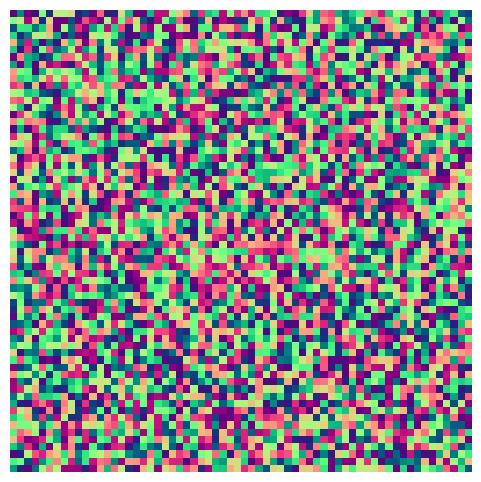

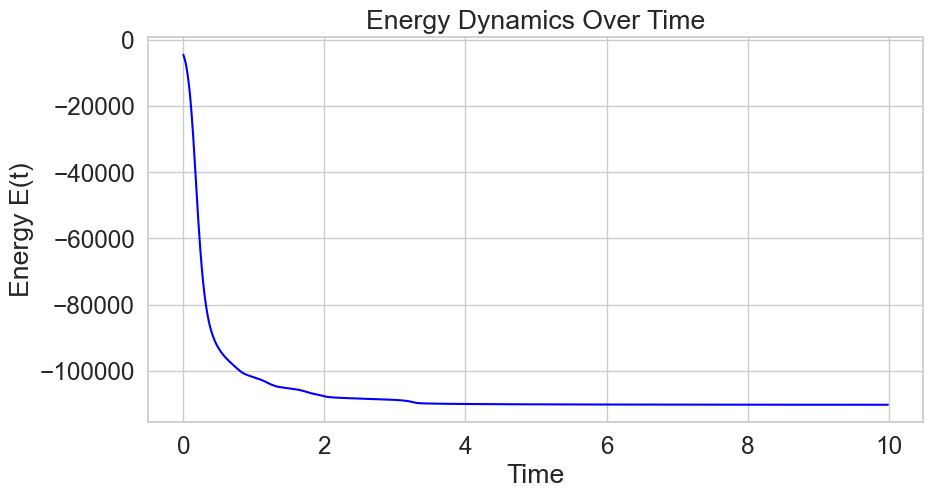

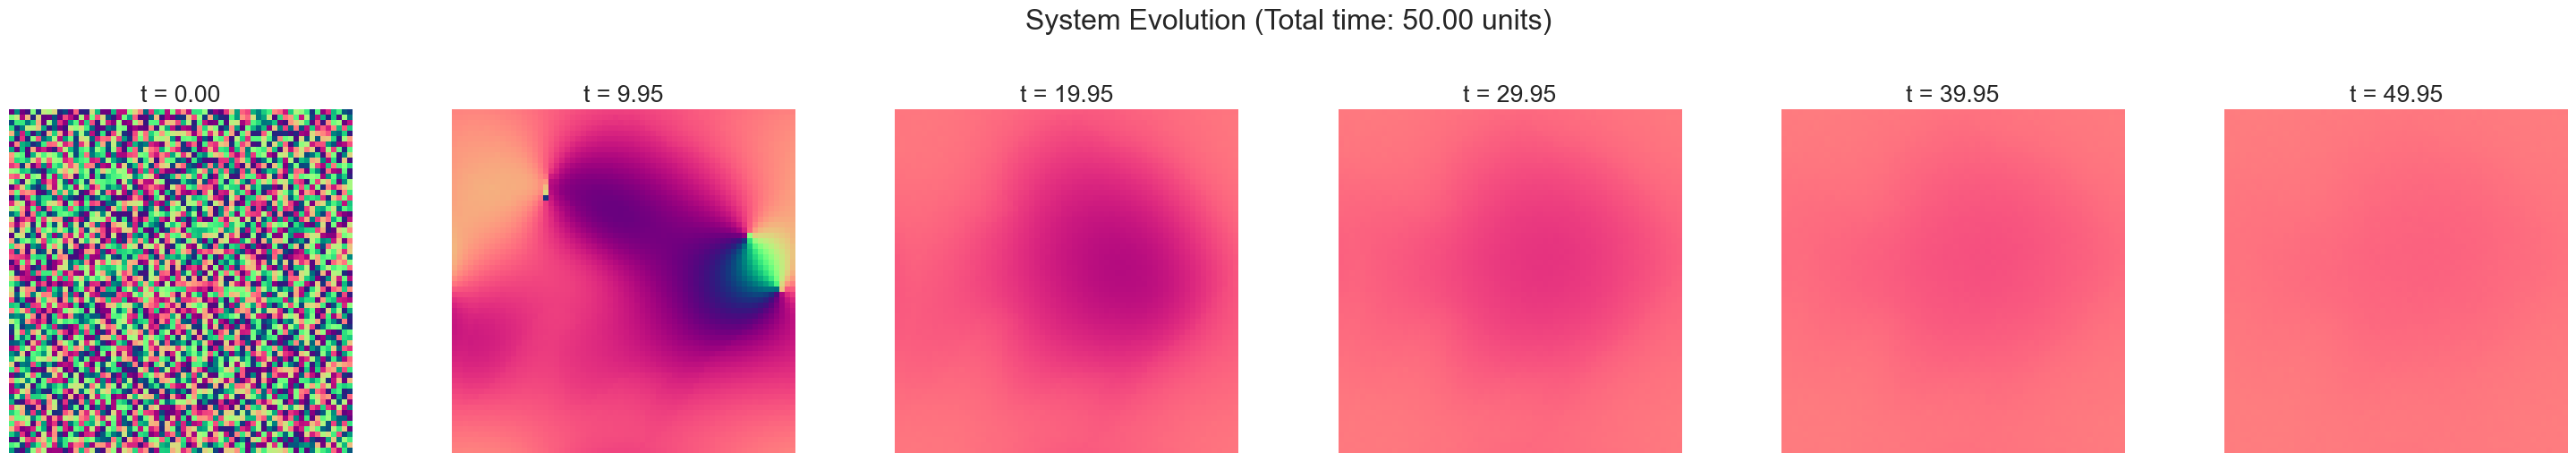

In [24]:
# generate RGB frames and animate
rgb_frames = map_to_rgb(act_mat, grid_size=grid_size, dim=dim)
animate_oscillators(rgb_frames, interval=100)

# plot energy
energies = compute_energy(act_mat, J, c_i, grid_size=grid_size, dim=dim)
plot_energy(energies, dt=dt)

# plot snapshots
plot_snapshots_dynamic(act_mat, grid_size=grid_size)